In [2]:
import os
import json
import time
import cv2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

Best validation loss:
iteration: 2999
loss: 0.2889543130555556


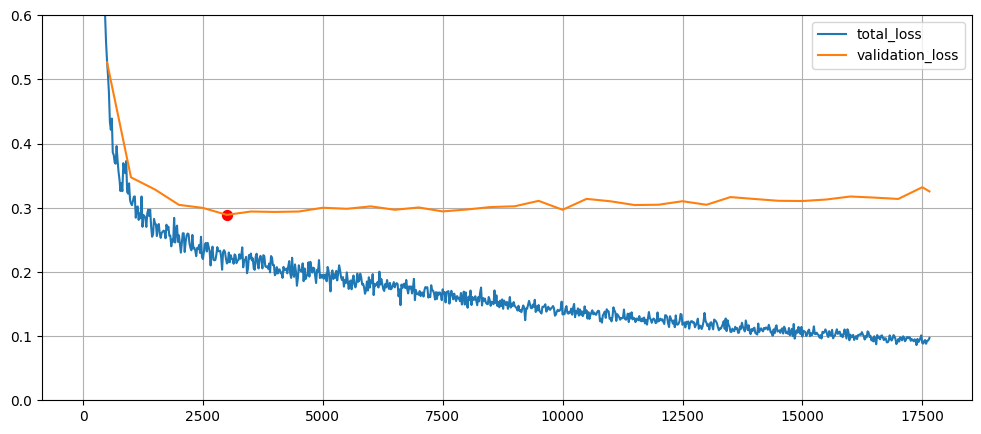

bbox AP:
bbox_AP: 70.12247668373497
bbox_AP_cap: 75.54699233583221
bbox_AP_glasses: 64.69796103163775


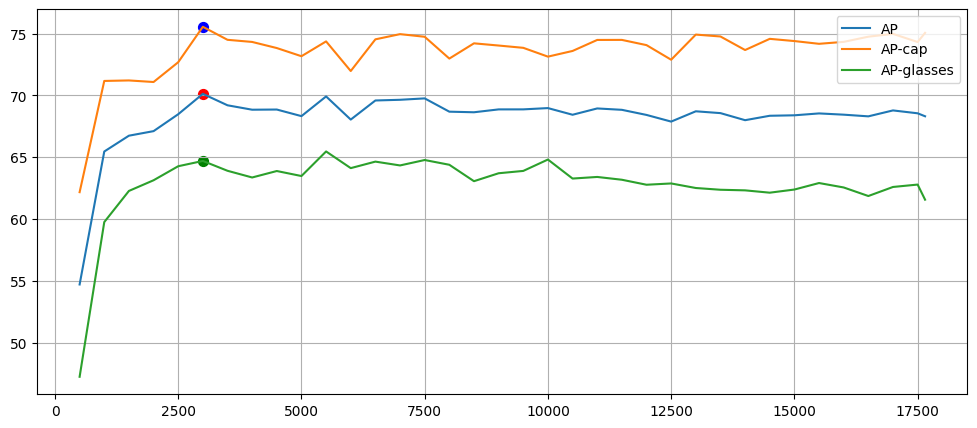

In [ ]:
experiment_folder = 'E:/detectron2/model/face_accessories_v2/'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

# total loss
total_loss_x = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
total_loss_y = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]

# validation loss
validation_loss_x = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
validation_loss_y = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]

# get best validation loss
min_val_loss = 99999999
for idx, x in enumerate(experiment_metrics):
    if 'validation_loss' in x and x['validation_loss'] < min_val_loss:
        min_val_loss = x['validation_loss']
        i = x['iteration']
        min_val_loss_idx = idx
print('Best validation loss:')
print(f'iteration: {i}')
print(f'loss: {min_val_loss}')

plt.figure(figsize=(12, 5))
plt.plot(total_loss_x, total_loss_y)
plt.plot(validation_loss_x, validation_loss_y)
plt.scatter(i, min_val_loss, color='red', s=50)
plt.legend(['total_loss', 'validation_loss'], loc='upper right')
plt.ylim(0, 0.6)
plt.grid()
plt.show()




# AP
bbox_AP_x = [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x]
bbox_AP_y = [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x]

# AP-cap
bbox_AP_cap_x = [x['iteration'] for x in experiment_metrics if 'bbox/AP-cap' in x]
bbox_AP_cap_y = [x['bbox/AP-cap'] for x in experiment_metrics if 'bbox/AP-cap' in x]

# AP-glasses
bbox_AP_glasses_x = [x['iteration'] for x in experiment_metrics if 'bbox/AP-glasses' in x]
bbox_AP_glasses_y = [x['bbox/AP-glasses'] for x in experiment_metrics if 'bbox/AP-glasses' in x]


# best AP
bbox_AP = bbox_AP_y[bbox_AP_x.index(i)]
bbox_AP_cap = bbox_AP_cap_y[bbox_AP_cap_x.index(i)]
bbox_AP_glasses = bbox_AP_glasses_y[bbox_AP_glasses_x.index(i)]
print(f'bbox_AP: {bbox_AP}')
print(f'bbox_AP_cap: {bbox_AP_cap}')
print(f'bbox_AP_glasses: {bbox_AP_glasses}')

plt.figure(figsize=(12, 5))
plt.plot(bbox_AP_x, bbox_AP_y)
plt.plot(bbox_AP_cap_x, bbox_AP_cap_y)
plt.plot(bbox_AP_glasses_x, bbox_AP_glasses_y)
plt.scatter(i, bbox_AP, color='red', s=50)
plt.scatter(i, bbox_AP_cap, color='blue', s=50)
plt.scatter(i, bbox_AP_glasses, color='green', s=50)
plt.legend(['AP', 'AP-cap', 'AP-glasses'], loc='upper right')
plt.grid()
plt.show()

# On One image

In [23]:
PARENT_FOLDER = 'E:/detectron2/model/face_accessories_v2/'

c:\Users\roger\anaconda3\envs\detectron2\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=t

Class 0: cap
Class 1: glasses
Instances(num_instances=2, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[112.0640, 192.7253, 388.5324, 309.7229],
        [ 64.5263,   1.1437, 431.4219, 192.3283]])), scores: tensor([0.9984, 0.9984]), pred_classes: tensor([1, 0])])


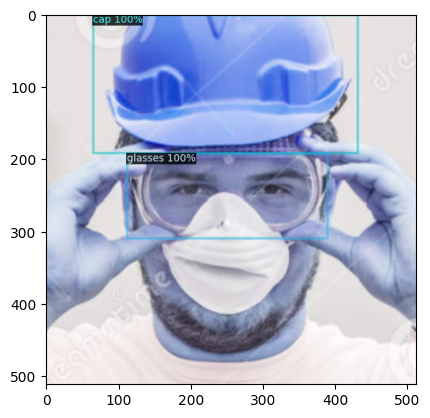

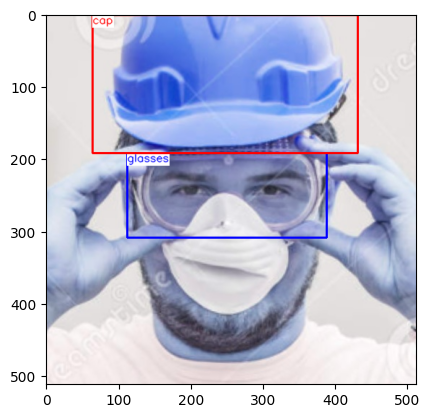

In [26]:
def set_metadata():
    # List of class names (labels) for your dataset
    class_names = ["cap", "glasses"]  

    # Define custom colors for each class (RGB values)
    thing_colors = [
        [255, 0, 0],    # Red for class 0 
        [0, 0, 255],    # Blue for class 1  
    ]

    # Create custom metadata for your dataset
    metadata = {
        "thing_classes": class_names,  # List of class names
        "thing_colors": thing_colors,  # List of colors for each class
    }

    # Register the metadata with the dataset name
    MetadataCatalog.get("face_accessories").set(**metadata)

# Function to configure the model for inference
def setup_inference(config_path, model_weights_path, score_thresh=0.3):
    cfg = get_cfg()
    cfg.set_new_allowed(True)
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = os.path.join(model_weights_path)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh  # Minimum score to keep a detection
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5    # IoU threshold for NMS                                                                                                                                                                                                                                                                                                                                                                     
    return cfg

# Function to perform inference on a single image
def inference_on_image(image_path, predictor, metadata=None, score_thresh=0.7):
    img = cv2.imread(image_path)
    outputs = predictor(img)
    instances = outputs["instances"]
    filtered_instances = instances
    filtered_instances = filtered_instances.to('cpu')

    print(filtered_instances)
    
    # Visualize results using visualizer
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    out = visualizer.draw_instance_predictions(filtered_instances)
    
    result_image = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
    plt.imshow(result_image)
    plt.show()

    # Visualize by manual drawing on original image
    for i in range(len(filtered_instances.pred_boxes)):
        coords = filtered_instances.pred_boxes.tensor[i].int().numpy()

        # draw boxes + write text
        if filtered_instances.pred_classes[i] == 0:
            draw_color = (255, 0, 0)
            text = 'cap'
        else:
            draw_color = (0, 0, 255)
            text = 'glasses'
        
        x_start = coords[0]
        y_start = coords[1]
        cv2.rectangle(img, (x_start, y_start), (coords[2], coords[3]), draw_color, 2)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = .5
        font_thickness = 1
        text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_w, text_h = text_size
        cv2.rectangle(img, (x_start, y_start), (x_start + text_w, y_start + text_h + 5), (255, 255, 255), -1)
        cv2.putText(img, text, (x_start, y_start + text_h), font, font_scale, draw_color, font_thickness, cv2.LINE_AA)

    plt.imshow(img)
    plt.show()

# Paths to your config file and trained model
config_path = PARENT_FOLDER + "/config.yaml"
model_weights_path = PARENT_FOLDER + "/model_0002999.pth"
image_path = "E:/paloma/task18/training_data/v2/valid/10887.jpg"
# image_path = "black.png"


# Set up the model for inference
cfg = setup_inference(config_path, model_weights_path, score_thresh=0.7)
predictor = DefaultPredictor(cfg)

# Load metadata (optional)
# metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])  # Replace with your dataset name
# Assuming you have registered your dataset (e.g., "laundry_train")
set_metadata()

metadata = MetadataCatalog.get("face_accessories")
# dataset_dicts = DatasetCatalog.get("laundry_train")
# Access the class names from the metadata
class_names = metadata.get("thing_classes", [])
# Print the class names with their corresponding indices
for idx, class_name in enumerate(class_names):
    print(f"Class {idx}: {class_name}")
    
# Perform inference
inference_on_image(image_path, predictor, metadata)

# All image in a folder

In [27]:
# Function to perform inference and save the results
def process_images_in_folder(input_folder, output_folder, predictor, metadata):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(file_path)
            st = time.time()
            outputs = predictor(img)
            instances = outputs["instances"]
            keep_indices = outputs["instances"].scores > 0.3
            filtered_instances = instances[keep_indices]
            
            visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
            out = visualizer.draw_instance_predictions(filtered_instances.to("cpu"))
            tt = time.time() - st
            print(tt)
            result_image = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
            
            output_path = os.path.join(output_folder, f"result_{file_name}")
            cv2.imwrite(output_path, result_image)
            print(f"Saved result to {output_path}")

# Paths to your config file and trained model
config_path = PARENT_FOLDER + "/config.yaml"
model_weights_path = PARENT_FOLDER + "/model_0002999.pth"
input_folder = "E:/paloma/task18/training_data/v2/valid"  # Folder containing input images
output_folder = "E:/detectron2/output/cap_glasses_v2_with_valid_0002999"  # Folder to save output images

# Set up the model for inference
cfg = setup_inference(config_path, model_weights_path, score_thresh=0.7)
predictor = DefaultPredictor(cfg)

# Set metadata
set_metadata()
metadata = MetadataCatalog.get("face_accessories")

# Process images in the input folder
process_images_in_folder(input_folder, output_folder, predictor, metadata)


c:\Users\roger\anaconda3\envs\detectron2\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=t

0.39384937286376953
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_00797.jpg
0.10306072235107422
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_00076.jpg
0.14135265350341797
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_11734.jpg
0.12067604064941406
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_00896.jpg
0.11090254783630371
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_00589.jpg
0.10872745513916016
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_00658.jpg
0.11028480529785156
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_11577.jpg
0.10881447792053223
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_10614.jpg
0.1123204231262207
Saved result to E:/detectron2/output/cap_glasses_v2_with_valid_0002999\result_10908.jpg
0.09465384483337402
Saved res